## ДЗ 2:
### Методы снижения размерности. Квантизация

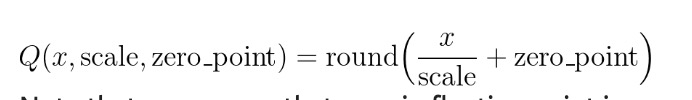

In [1]:
import ultralytics
from ultralytics import YOLO

In [2]:
import torch
import time
import torch.quantization
from torch import profiler
from torch.profiler import profile, record_function, ProfilerActivity

In [3]:
torch.seed = 42

In [4]:
def get_model_size(model: torch.nn.Module) -> float:
    """return model size im mb"""
    param_size = 0
    for param in model.parameters():
        param_size += param.nelement() * param.element_size()
    buffer_size = 0
    for buffer in model.buffers():
        buffer_size += buffer.nelement() * buffer.element_size()

    return (param_size + buffer_size) / 1024**2

In [5]:
def profile_model(model, input_example: torch.Tensor = torch.randn(1, 3, 224, 224)):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    input_example = input_example.to(device)

    # cold run
    for _ in range(3):
        model(input_example)

    with profile(activities=[ProfilerActivity.CPU], profile_memory=True, with_flops=True) as prof:
        with record_function("model_inference"):
            with torch.inference_mode():
                model(input_example)

    profiling_info = prof.key_averages().table(sort_by="cpu_time_total", row_limit=1)
    return profiling_info

### Исходная модель

In [33]:
yolo = YOLO('yolov8s.pt')
model = yolo.model
model.fuse()
model.eval()
print()

YOLOv8s summary (fused): 168 layers, 11156544 parameters, 0 gradients, 28.6 GFLOPs


In [48]:
print(profile_model(model))
print(f'model size: {get_model_size(model)}')

---------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                             Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg       CPU Mem  Self CPU Mem    # of Calls  Total KFLOPs  
---------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                  model_inference        -3.03%   -3241.000us       100.00%     107.026ms     107.026ms           0 b     -23.75 Mb             1            --  
---------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
Self CPU time total: 107.026ms

model size: 42.558837890625


STAGE:2023-10-13 14:04:59 78723:2833521 ActivityProfilerController.cpp:311] Completed Stage: Warm Up
STAGE:2023-10-13 14:04:59 78723:2833521 ActivityProfilerController.cpp:317] Completed Stage: Collection
STAGE:2023-10-13 14:04:59 78723:2833521 ActivityProfilerController.cpp:321] Completed Stage: Post Processing


### Динамическая квантизация

In [39]:
dynamic_quantized_model = torch.quantization.quantize_dynamic(model, dtype=torch.qint8)

In [47]:
print(profile_model(quantized))
print(f'model size: {get_model_size(quantized)}')

---------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                             Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg       CPU Mem  Self CPU Mem    # of Calls  Total KFLOPs  
---------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                  model_inference       -11.15%  -11702.000us       100.00%     104.930ms     104.930ms           0 b     -25.97 Mb             1            --  
---------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
Self CPU time total: 104.930ms

model size: 42.558837890625


STAGE:2023-10-13 14:04:53 78723:2833521 ActivityProfilerController.cpp:311] Completed Stage: Warm Up
STAGE:2023-10-13 14:04:53 78723:2833521 ActivityProfilerController.cpp:317] Completed Stage: Collection
STAGE:2023-10-13 14:04:53 78723:2833521 ActivityProfilerController.cpp:321] Completed Stage: Post Processing


### Статическая квантизация

In [49]:
torch.quantization.prepare(model, inplace=True)
print()

/Users/timur/.pyenv/versions/3.8.0/lib/python3.8/site-packages/torch/ao/quantization/quantize.py:310: UserWarning: None of the submodule got qconfig applied. Make sure you passed correct configuration through `qconfig_dict` or by assigning the `.qconfig` attribute directly on submodules
  warnings.warn("None of the submodule got qconfig applied. Make sure you "


In [50]:
model.qconfig = torch.ao.quantization.get_default_qconfig('x86')

In [51]:
quantized = torch.quantization.convert(model, inplace=False)

In [54]:
print(profile_model(quantized))
print(f'model size: {get_model_size(model)}')

---------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                             Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg       CPU Mem  Self CPU Mem    # of Calls  Total KFLOPs  
---------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                  model_inference        -1.57%   -1652.000us       100.00%     105.200ms     105.200ms           0 b     -23.96 Mb             1            --  
---------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
Self CPU time total: 105.200ms

model size: 42.558837890625


STAGE:2023-10-13 14:06:52 78723:2833521 ActivityProfilerController.cpp:311] Completed Stage: Warm Up
STAGE:2023-10-13 14:06:52 78723:2833521 ActivityProfilerController.cpp:317] Completed Stage: Collection
STAGE:2023-10-13 14:06:52 78723:2833521 ActivityProfilerController.cpp:321] Completed Stage: Post Processing


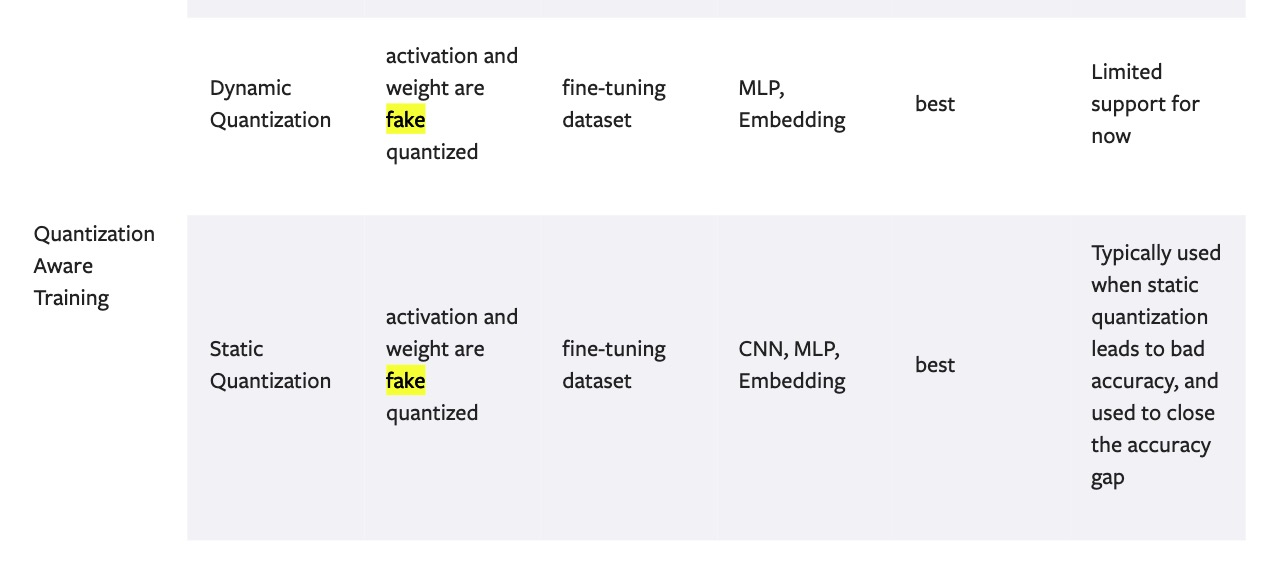